## Roundoff error in long term integrations of planetary orbits

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# Useful constants
GM_Sun = 1.3271 * 10**20
Earth_Sun = 1.496 * 10**11 # Distance Earth-Sun in meters

Assuming a circular orbit, we can use $F=ma$ to derive the initial velocity. Let the Sun be at the origin, and the Earth be at $\theta$ = 0 with a completely upward velocity. The distance Earth-Sun is set to 1AU.

In [73]:
def orbit(dt):
    # Set time
    dt_sec = dt*31557600
    time = np.arange(0, 31557600, dt_sec) # 31557600 seconds in a year

    # Initial values
    x = [Earth_Sun]
    y = [0]
    vx = [0]
    vy = [(GM_Sun/Earth_Sun)**0.5]

    for t in time:
        # Calculate distance to Sun
        d = (x[-1]**2 + y[-1]**2)**0.5
        # Calculate acceleration
        ax = -GM_Sun * x[-1] / d**3 
        ay = -GM_Sun * y[-1] / d**3

        # Update and store velocity
        vx.append(vx[-1] + ax * dt_sec)
        vy.append(vy[-1] + ay * dt_sec)

        # Update and store position
        x.append(x[-1] + vx[-1] * dt_sec)
        y.append(y[-1] + vy[-1] * dt_sec)

    return [x, y, vx, vy]

Text(0, 0.5, 'y-distance (m)')

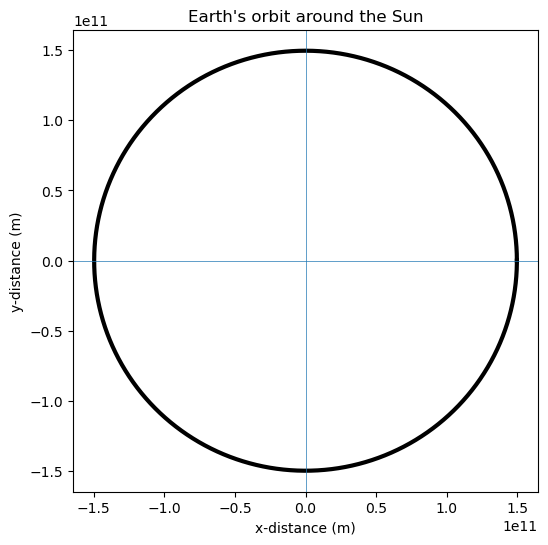

In [74]:
# Plotting
plt.figure(figsize=(6, 6))
plt.plot(orbit(0.0001)[0], orbit(0.0001)[1], 'k', linewidth = 3)
plt.axvline(0, linewidth = 0.5)
plt.axhline(0, linewidth = 0.5)
plt.title("Earth's orbit around the Sun")
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')

The Earth moves as expected around a circular orbit, as per the assumptions.

In [75]:
# Calculate fractional difference in energy
def energy(x, y, vx, vy):
    # The mass of the Earth cancels in the calculation
    initial = -GM_Sun/(x[0]**2+y[0]**2)**0.5 + (vx[0]**2+vy[0]**2)/2
    final = -GM_Sun/(x[-1]**2+y[-1]**2)**0.5 + (vx[-1]**2+vy[-1]**2)/2
    return (initial - final) / initial

In [76]:
# Set timestep
timestep = 10**np.linspace(-7, -1, 100)
n = 1/timestep
delta_energy = []

# Call energy() and store the value
for t in timestep:
    o = orbit(t)
    delta_energy.append(energy(o[0], o[1], o[2], o[3]))

[]

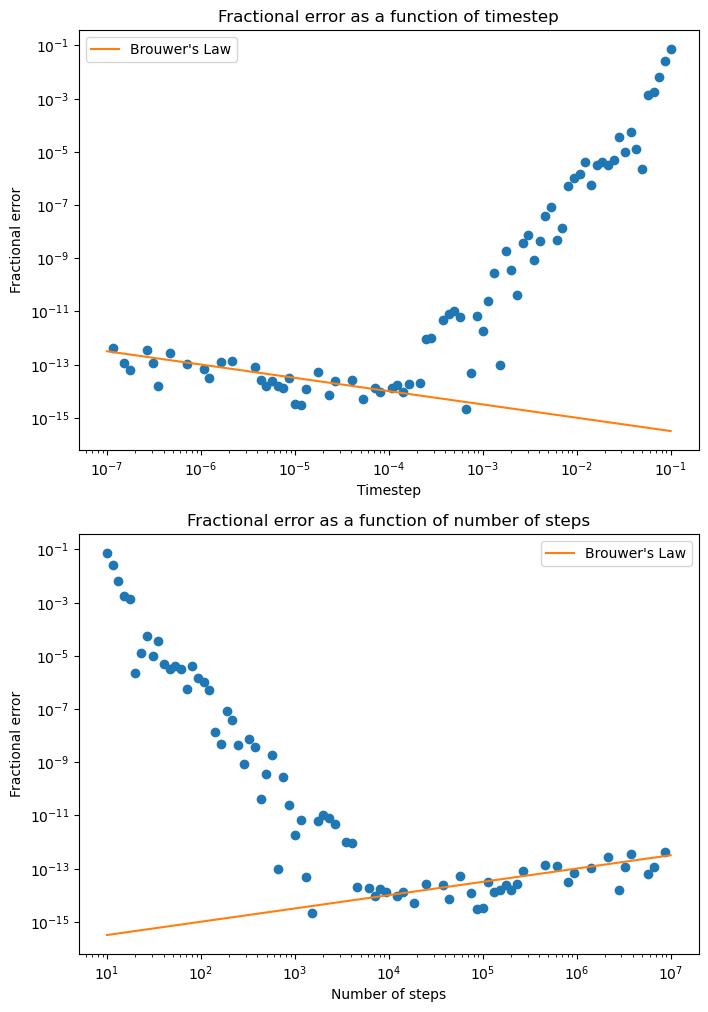

In [80]:
# Plotting
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(timestep, delta_energy, 'o')
plt.plot(1/n, np.sqrt(n)*10**-16, label = "Brouwer's Law")
plt.title('Fractional error as a function of timestep')
plt.xlabel('Timestep')
plt.ylabel('Fractional error')
plt.legend()
plt.loglog()

plt.subplot(2, 1, 2)
plt.plot(n, delta_energy, 'o')
plt.plot(n, np.sqrt(n)*10**-16, label = "Brouwer's Law")
plt.title('Fractional error as a function of number of steps')
plt.xlabel('Number of steps')
plt.ylabel('Fractional error')
plt.legend()
plt.loglog()

Observing from the second plot, we can see that the fractional error decreases as the number of steps increases, until about $10^4$ steps. After that point, despite the fluctuations of the data points, we can see a general trend of the fractional error increasing. For an increase of about 3 orders of magnitude in the number of steps, the fractional error increases by about 1.5 to 2 orders of magnitude, obeying Brouwer's law.

For a small number of steps, the error comes from the semi-implicit Euler method, since the integration is not as smooth. For a large number of steps, the error in Euler's method becomes less significant and we see Brouwer's law take over.

## Interpolation and Thermodynamics

In [3]:
import scipy.interpolate
from matplotlib import ticker

In [35]:
# Set up sample points and constants
sample_rho = np.logspace(-6, 0, 10)
sample_t = np.logspace(2, 3, 10)
rho = np.logspace(-6, 0, 100)
t = np.logspace(2, 3, 100)

m = 28*1.66054*10**-27
kb = 1.380649 * 10**-23
h_bar = 1.054571817 * 10**-34

[]

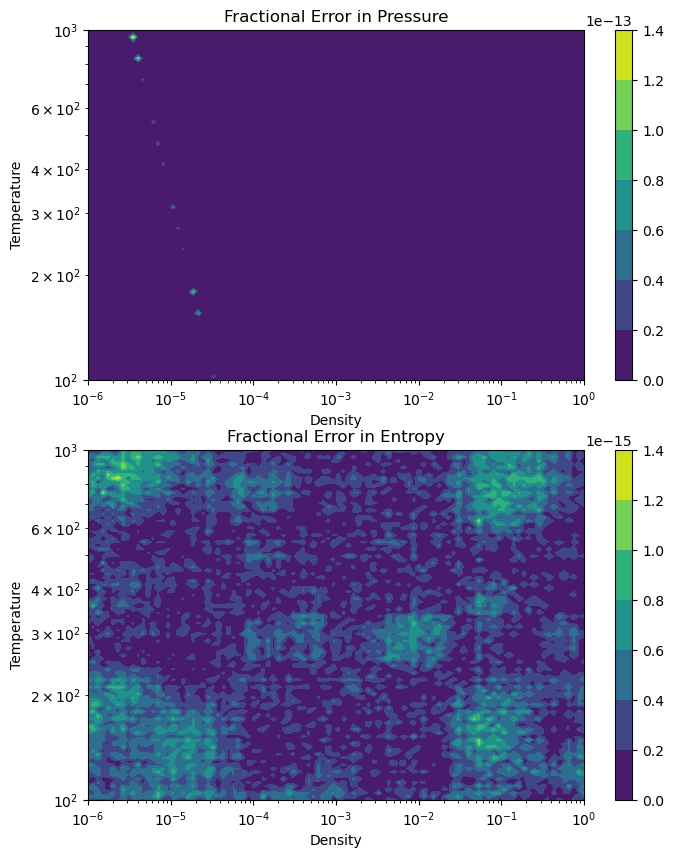

In [36]:
# Calculate pressure and entropy according to formulae
def pressure(density, temperature):
    res = []
    for d in density:
        res.append(d/m * kb * temperature)
    return res

def entropy(density, temperature):
    res = []
    for d in density:
        res.append(kb * (5/2 - np.log((d/m)/(m * kb * temperature/(2*np.pi*h_bar**2))**1.5)))
    return res

# Calculate log10(pressure) and entropy/Kb
logP = np.log10(pressure(sample_rho, sample_t))
s_kb = np.divide(entropy(sample_rho, sample_t), kb)

# Interpolate
fp = scipy.interpolate.RectBivariateSpline(np.log10(sample_rho), np.log10(sample_t), logP)
fe = scipy.interpolate.RectBivariateSpline(np.log10(sample_rho), np.log10(sample_t), s_kb)

interpolated_p = fp(np.log10(rho), np.log10(t))
interpolated_e = fe(np.log10(rho), np.log10(t))

# Calculate errors
err_p = abs((interpolated_p - np.log10(pressure(rho, t))) / np.log10(pressure(rho, t)))
err_e = abs((interpolated_e - np.divide(entropy(rho, t), kb)) / np.divide(entropy(rho, t), kb))

# Plotting
x, y = np.meshgrid(rho, t, indexing='ij')

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
pressure_map = plt.contourf(x, y, err_p)
plt.colorbar(pressure_map)
plt.title('Fractional Error in Pressure')
plt.xlabel('Density')
plt.ylabel('Temperature')
plt.loglog()

plt.subplot(2, 1, 2)
entropy_map = plt.contourf(x, y, err_e)
plt.colorbar(entropy_map)
plt.title('Fractional Error in Entropy')
plt.xlabel('Density')
plt.ylabel('Temperature')
plt.loglog()

To calculate the partial derivatives, we can use the partial_derivative() function from scipy.interpolate.RectBivariateSpline. The partial derivative for pressure is computed as

\begin{equation}
    \frac{\partial \log_{10}(P)}{\partial \log_{10}(T)}
\end{equation}

The partial derivative for entropy is computed as

\begin{equation}
    \frac{\partial \left(\frac{S}{K_b}\right)}{\partial \log_{10}(\rho)}
\end{equation}

However, we need to compute $$\partial S\over \partial n $$ and $$ \partial P\over \partial T $$

By substitution, we get 

\begin{equation}
    \frac{\partial P}{\partial T} = \frac{\partial \log_{10}(P)}{\partial \log_{10}(T)} \cdot \frac{P}{T}
\end{equation}

and

\begin{equation}
    \frac{\partial S}{\partial n} = \frac{28m_uK_b}{\rho \ln(10)} \cdot \frac{\partial \left(\frac{S}{K_b}\right)}{\partial \log_{10}(\rho)}
\end{equation}

Text(0, 0.5, 'Temperature')

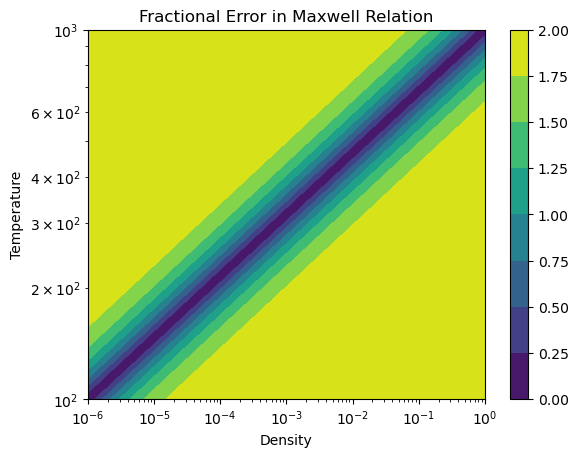

In [51]:
# Partial derivatives
dp = fp.partial_derivative(0, 1)
ds = fe.partial_derivative(1, 0)

# Compute LHS and RHS
lhs = -m * kb * ds(rho, t) / (rho * np.log(10))
rhs = dp(rho, t) * pressure(rho, t) / ((rho/m)**2 * t)
err = abs((lhs-rhs)/((lhs+rhs)/2))

maxwell = plt.contourf(x, y, err)
plt.loglog()
plt.colorbar(maxwell)
plt.title('Fractional Error in Maxwell Relation')
plt.xlabel('Density')
plt.ylabel('Temperature')

This is indeed a surprise.

The Maxwell relation is
$$-\left.{\partial S\over \partial n}\right|_T = {1\over n^2}\left.{\partial P\over \partial T}\right|_n$$

Analytically, we can derive the derivatives to see their dependence on pressure and temperature. From the equation for entropy, we get that the left hand side is

\begin{equation}
    -\frac{\partial S}{\partial n} = K_b \cdot \frac{1}{\frac{n}{n_Q}} \cdot \frac{1}{n_Q} = \frac{K_b}{n_Q}
\end{equation}

Therefore, the equation should only depend on $\rho$ and constant across $T$. However, the graph shows variations in the $T$ direction, which is quite unexpected.

To make sure that the values of the derivatives are correct, we can analytically calculate the expected values.

\begin{equation}
    \frac{\partial \log_{10}(P)}{\partial \log_{10}(T)} = \frac{\partial P}{\partial T} \cdot \frac{T}{P}
    = nK_b \cdot \frac{T}{nK_bT} = 1
\end{equation}

\begin{equation}
      \frac{\partial \left(\frac{S}{K_b}\right)}{\partial \log_{10}(\rho)} = \frac{1}{K_b} \cdot
      \frac{\partial S}{\partial \rho} \cdot \rho \ln(10) = \frac{1}{28m_uK_b} \cdot \frac{\partial S}{\partial n}
      \cdot \rho \ln(10) = \frac{1}{28m_uK_b} \cdot -\frac{K_b}{n} \cdot \rho \ln(10) = -\ln(10)
\end{equation}

In [53]:
# print(dp(rho, t)) # =1
# print(ds(rho, t)) # =-2.3

The values of the derivatives match with the expected values. Furthermore, they are constant across the $\rho$-$T$ plane, which is also expected from the analytical values.

Although the interpolation should be thermodynamically consistent, the plot above suggest inconsistency as we move away from the data points. It is a surprise since a cubic spline should approximate exactly polynomials of degree 3 or less, and the equation of state has a linear scaling. For more complicated equations of state (with a polynomial of degree 4 or more), I would not expect the cubic spline to be a good approximation.

Since the values of the derivatives are correct, and I am pretty sure that the math is also correct, there must be a mistake *somewhere* in the code when computing the LHS and the RHS of the Maxwell relation. 